# Student Dropout Prediction

In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import pickle


from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier


In [3]:
df = pd.read_csv("dataset.csv")
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nationality,Mother's qualification,Father's qualification,Mother's occupation,...,2ndsem credited,2ndsem enrolled,2ndsem evaluations,2ndsem approved,2ndsem grade,2ndsem without evaluations,Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [4]:
df.iloc[:5,:].T

,0,1,2,3,4
Marital status,1,1,1,1,2
Application mode,8,6,1,8,12
Application order,5,1,5,2,1
Course,2,11,5,15,3
Daytime/evening attendance,1,1,1,1,0
Previous qualification,1,1,1,1,1
Nationality,1,1,1,1,1
Mother's qualification,13,1,22,23,22
Father's qualification,10,3,27,27,28
Mother's occupation,6,4,10,6,10


In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   marital_status              4424 non-null   int64  
 1   application_mode            4424 non-null   int64  
 2   application_order           4424 non-null   int64  
 3   course                      4424 non-null   int64  
 4   daytime/evening_attendance  4424 non-null   int64  
 5   previous_qualification      4424 non-null   int64  
 6   nationality                 4424 non-null   int64  
 7   mother's_qualification      4424 non-null   int64  
 8   father's_qualification      4424 non-null   int64  
 9   mother's_occupation         4424 non-null   int64  
 10  father's_occupation         4424 non-null   int64  
 11  displaced                   4424 non-null   int64  
 12  educational_special_needs   4424 non-null   int64  
 13  debtor                      4424 

In [7]:
categorical = ['marital_status', 'application_mode', 'course', 'daytime/evening_attendance'
      ,'previous_qualification','nationality',  "mother's_qualification", "father's_qualification",
       "mother's_occupation", "father's_occupation", 'displaced', 'educational_special_needs',
       'debtor', 'uptodate_fees', 'gender', 'scholarship_holder', 'international']

numerical = ['application_order','enrollment_age','1stsem_credited','1stsem_enrolled','1stsem_evaluations',
 '1stsem_approved', '1stsem_grade', '1stsem_without_evaluations', '2ndsem_credited', '2ndsem_enrolled',
 '2ndsem_evaluations', '2ndsem_approved', '2ndsem_grade', '2ndsem_without_evaluations', 'unemployment_rate',
 'inflation_rate','gdp']

In [8]:
for s in categorical:
    df[s]  = df[s].astype("category")

# Exploratory Data Analysis (EDA)

In [9]:
enrolled_df = df[df['target'] == "enrolled"]

In [10]:
df = df[df['target'] != "enrolled"]

In [11]:
df.isnull().sum()

marital_status                0
application_mode              0
application_order             0
course                        0
daytime/evening_attendance    0
previous_qualification        0
nationality                   0
mother's_qualification        0
father's_qualification        0
mother's_occupation           0
father's_occupation           0
displaced                     0
educational_special_needs     0
debtor                        0
uptodate_fees                 0
gender                        0
scholarship_holder            0
enrollment_age                0
international                 0
1stsem_credited               0
1stsem_enrolled               0
1stsem_evaluations            0
1stsem_approved               0
1stsem_grade                  0
1stsem_without_evaluations    0
2ndsem_credited               0
2ndsem_enrolled               0
2ndsem_evaluations            0
2ndsem_approved               0
2ndsem_grade                  0
2ndsem_without_evaluations    0
unemploy

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3630 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   marital_status              3630 non-null   category
 1   application_mode            3630 non-null   category
 2   application_order           3630 non-null   int64   
 3   course                      3630 non-null   category
 4   daytime/evening_attendance  3630 non-null   category
 5   previous_qualification      3630 non-null   category
 6   nationality                 3630 non-null   category
 7   mother's_qualification      3630 non-null   category
 8   father's_qualification      3630 non-null   category
 9   mother's_occupation         3630 non-null   category
 10  father's_occupation         3630 non-null   category
 11  displaced                   3630 non-null   category
 12  educational_special_needs   3630 non-null   category
 13  debtor            

In [13]:
df.describe()

,application_order,enrollment_age,1stsem_credited,1stsem_enrolled,1stsem_evaluations,1stsem_approved,1stsem_grade,1stsem_without_evaluations,2ndsem_credited,2ndsem_enrolled,2ndsem_evaluations,2ndsem_approved,2ndsem_grade,2ndsem_without_evaluations,unemployment_rate,inflation_rate,gdp
count,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000
mean,1.750138,23.461157,0.754270,6.337466,8.071074,4.791460,10.534860,0.128926,0.581818,6.296419,7.763085,4.518457,10.036155,0.142149,11.630358,1.231598,-0.009256
std,1.333831,7.827994,2.477277,2.570773,4.286632,3.237845,5.057694,0.679111,2.022688,2.263020,3.964163,3.162376,5.481742,0.747670,2.667652,1.384911,2.259986
min,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,19.000000,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.517857,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,20.000000,0.000000,6.000000,8.000000,5.000000,12.341429,0.000000,0.000000,6.000000,8.000000,5.000000,12.333333,0.000000,11.100000,1.400000,0.320000
75%,2.000000,25.000000,0.000000,7.000000,10.000000,6.000000,13.500000,0.000000,0.000000,7.000000,10.000000,6.000000,13.500000,0.000000,13.900000,2.600000,1.790000
max,6.000000,70.000000,20.000000,26.000000,45.000000,26.000000,18.875000,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


In [14]:
df[categorical].describe(include='all')

,marital_status,application_mode,course,daytime/evening_attendance,previous_qualification,nationality,mother's_qualification,father's_qualification,mother's_occupation,father's_occupation,displaced,educational_special_needs,debtor,uptodate_fees,gender,scholarship_holder,international
count,3630,3630,3630,3630,3630,3630,3630,3630,3630,3630,3630,3630,3630,3630,3630,3630,3630
unique,6,18,17,2,17,19,29,34,29,42,2,2,2,2,2,2,2
top,1,1,12,1,1,1,1,27,10,10,1,0,0,1,0,0,0
freq,3199,1408,666,3222,3019,3544,865,1010,1313,847,1993,3590,3217,3144,2381,2661,3544


In [15]:
# sns.pairplot(df[numerical])

<BarContainer object of 2 artists>

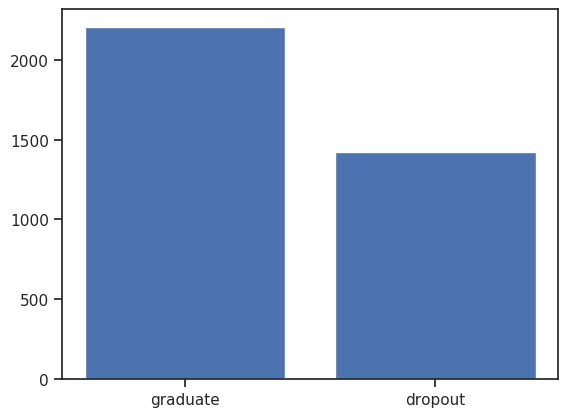

In [16]:
target_info = df.target.value_counts()
plt.bar(target_info.index,target_info.values)

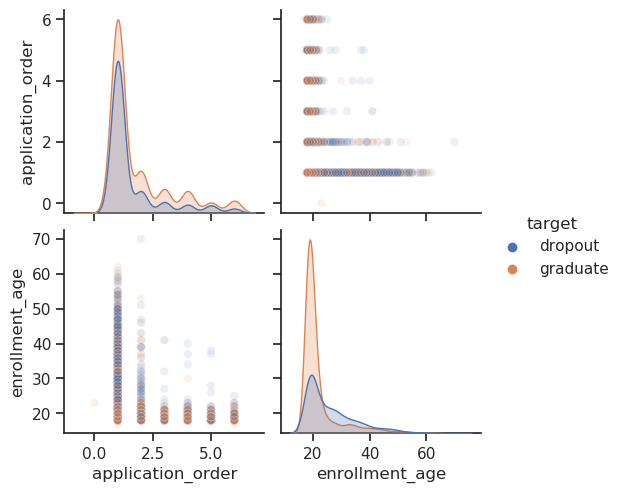

In [17]:
sns.pairplot(df[['application_order','enrollment_age','target']], hue = 'target', plot_kws={'alpha':0.1})

In [18]:
def plot_dataframe_columns(df, columns):
    for col in columns:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")

    num_plots = len(columns)
    num_rows = (num_plots // 2) + (num_plots % 2)  

    plt.figure(figsize=(12, 6 * num_rows)) 

    for i, col in enumerate(columns, 1):
        plt.subplot(num_rows, 2, i)  
        plt.hist(df[col])
        plt.title(col)
        plt.xlabel(f'{col}')
        plt.ylabel(f'{col} height')

    plt.tight_layout()
    plt.show()



In [19]:
df[numerical].columns

Index(['application_order', 'enrollment_age', '1stsem_credited',
       '1stsem_enrolled', '1stsem_evaluations', '1stsem_approved',
       '1stsem_grade', '1stsem_without_evaluations', '2ndsem_credited',
       '2ndsem_enrolled', '2ndsem_evaluations', '2ndsem_approved',
       '2ndsem_grade', '2ndsem_without_evaluations', 'unemployment_rate',
       'inflation_rate', 'gdp'],
      dtype='object')

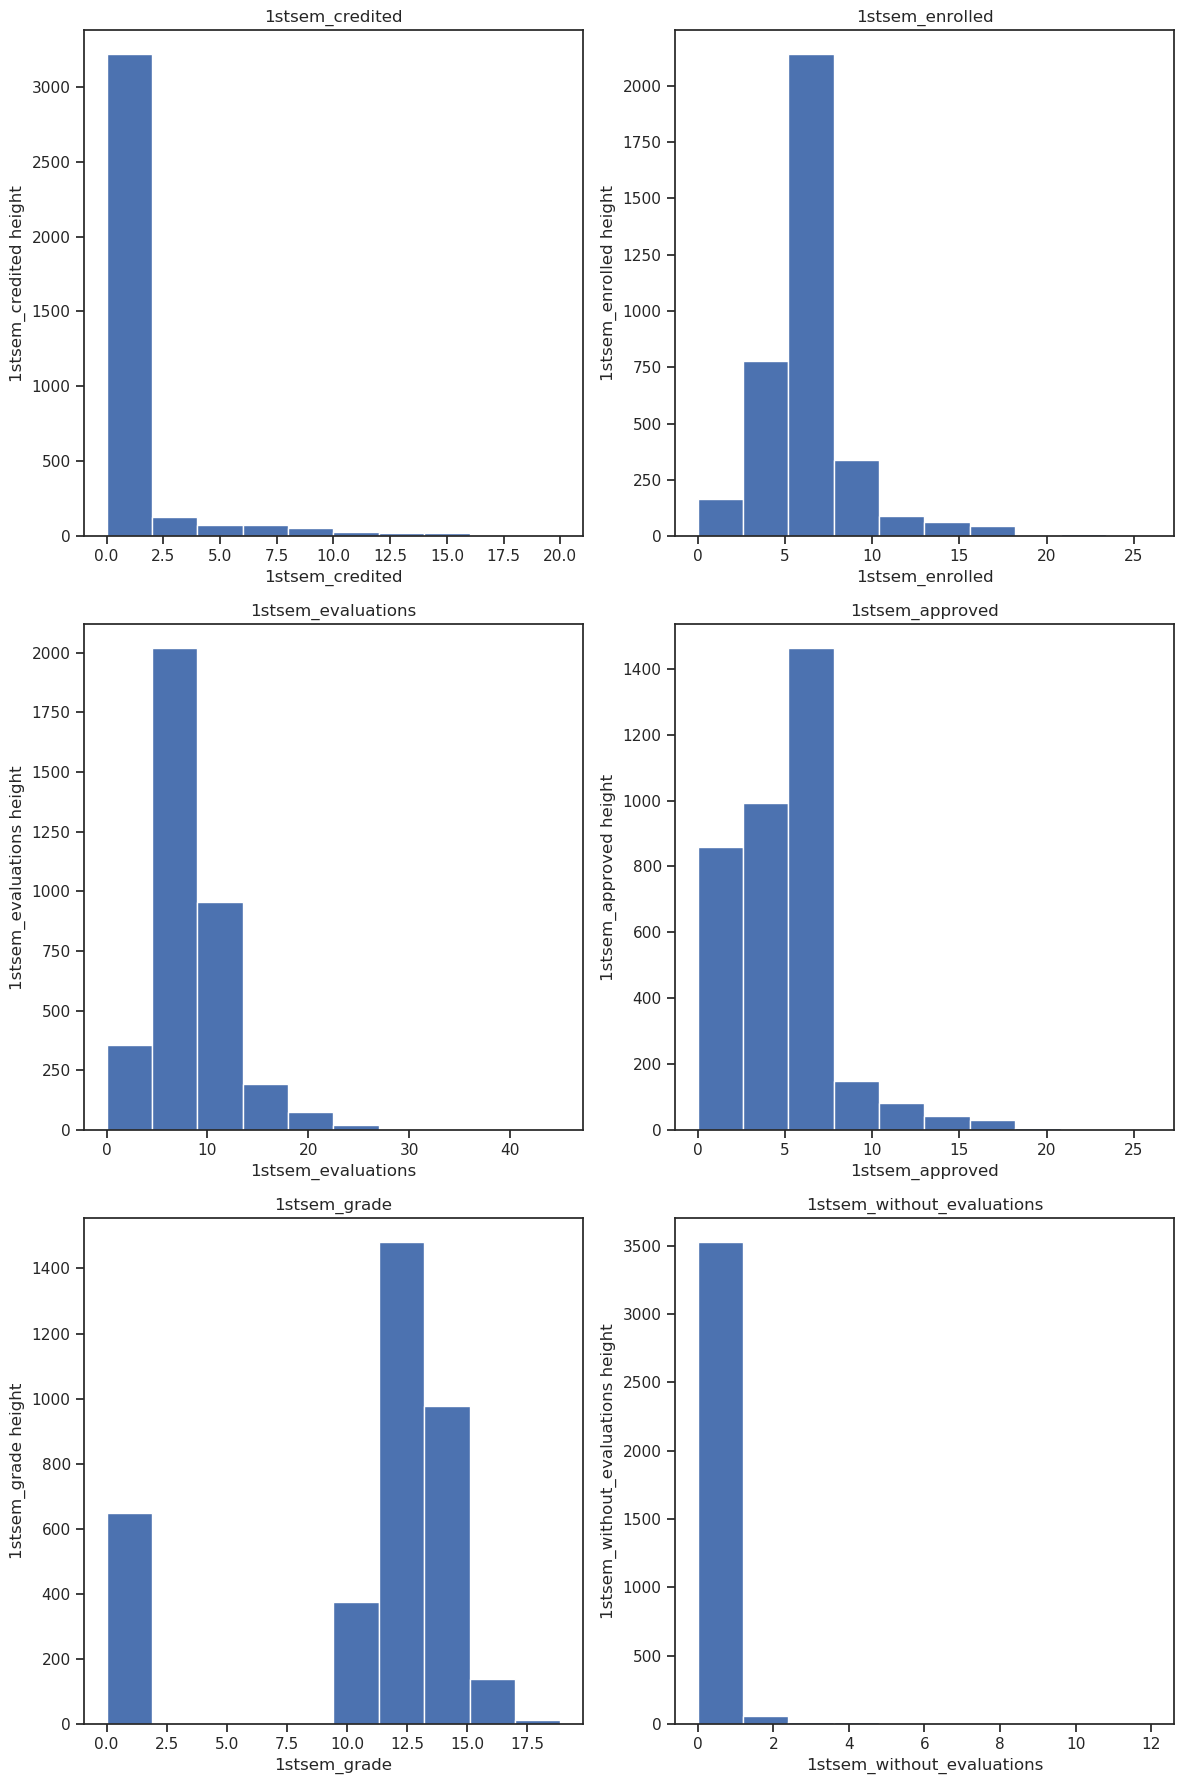

In [20]:

plot_dataframe_columns(df, ['1stsem_credited','1stsem_enrolled','1stsem_evaluations',
 '1stsem_approved', '1stsem_grade', '1stsem_without_evaluations'])

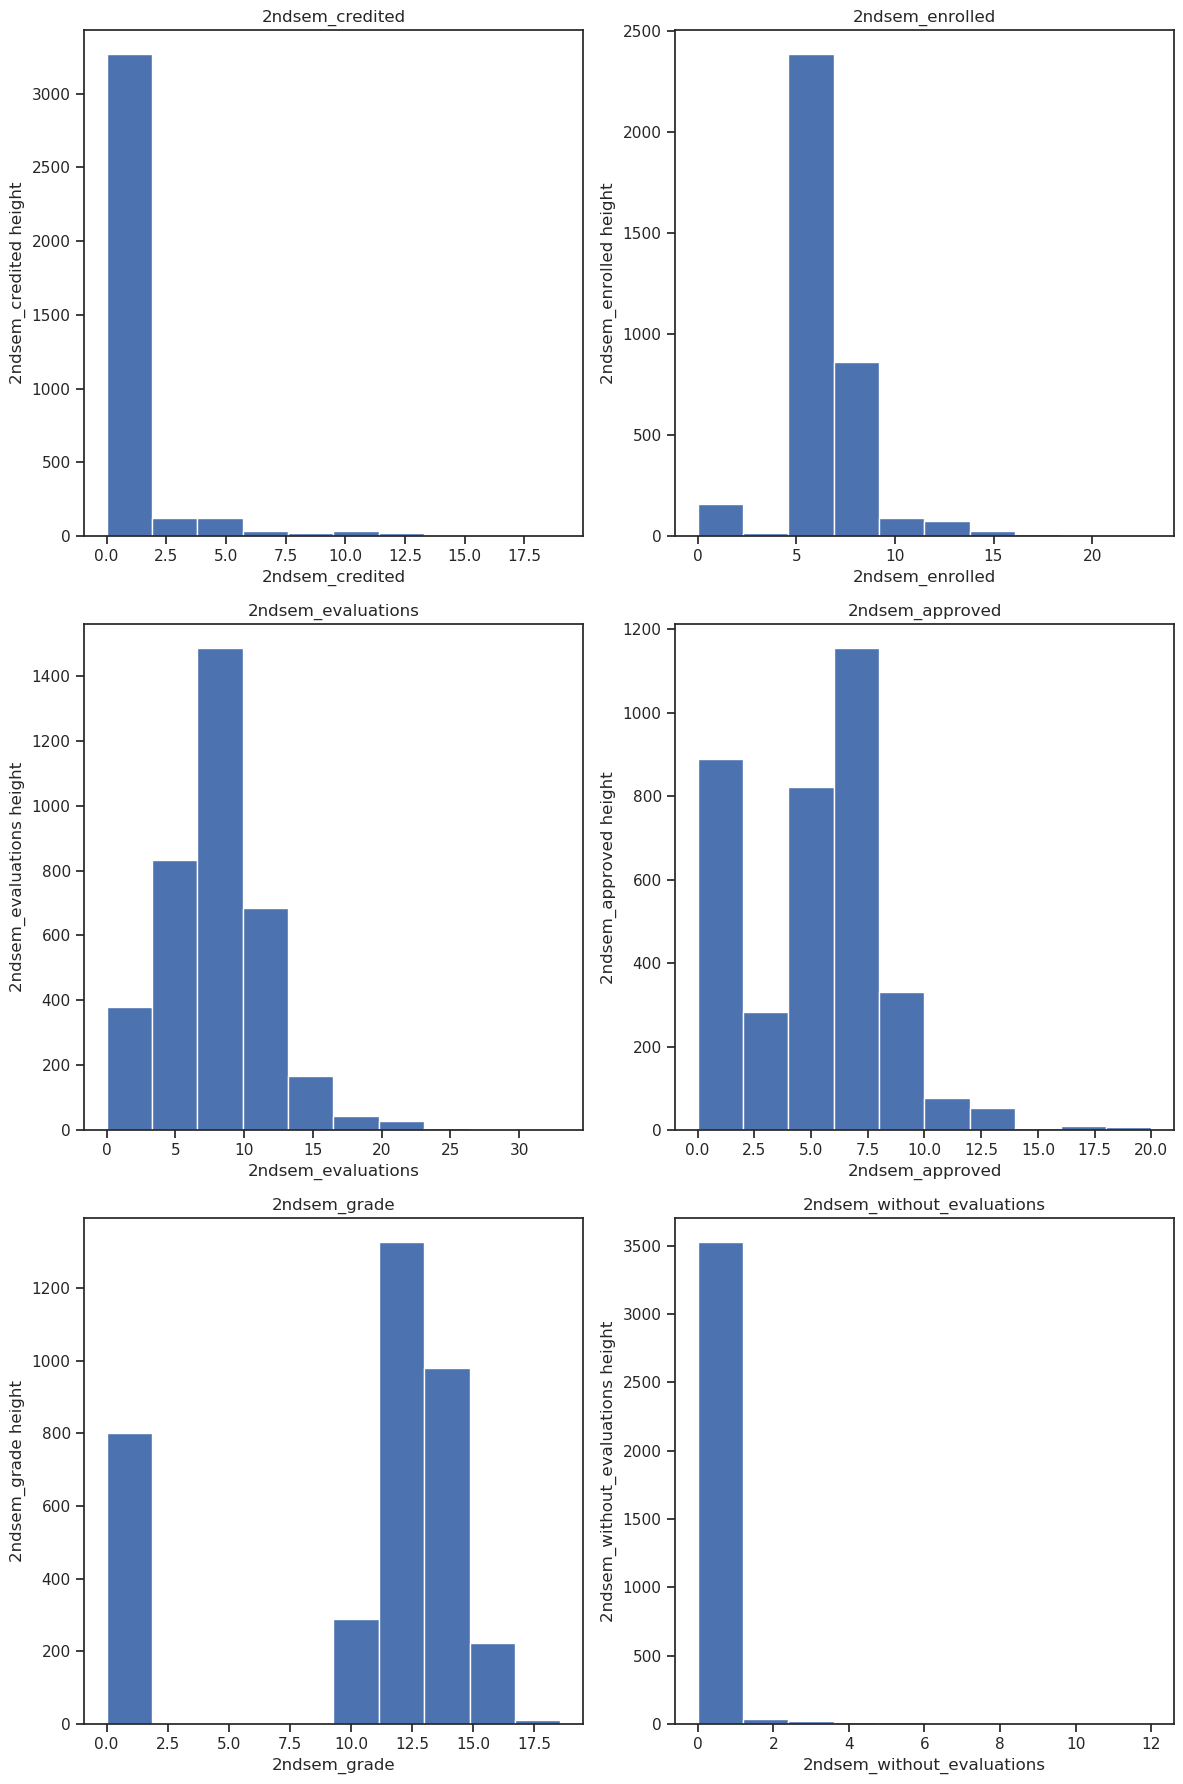

In [21]:
plot_dataframe_columns(df, ['2ndsem_credited', '2ndsem_enrolled',
 '2ndsem_evaluations', '2ndsem_approved', '2ndsem_grade', '2ndsem_without_evaluations'])

In [22]:
def plot_categorical_columns(df, columns):
    for col in columns:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")

    num_plots = len(columns)
    num_rows = (num_plots // 2) + (num_plots % 2)  
    plt.figure(figsize=(12, 6 * num_rows))  
    for i, col in enumerate(columns, 1):
        bar_values = df[col].value_counts()
        plt.subplot(num_rows, 2, i)  
        plt.bar(bar_values.index, bar_values.values)
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel('bar height')

    plt.tight_layout()
    plt.show()


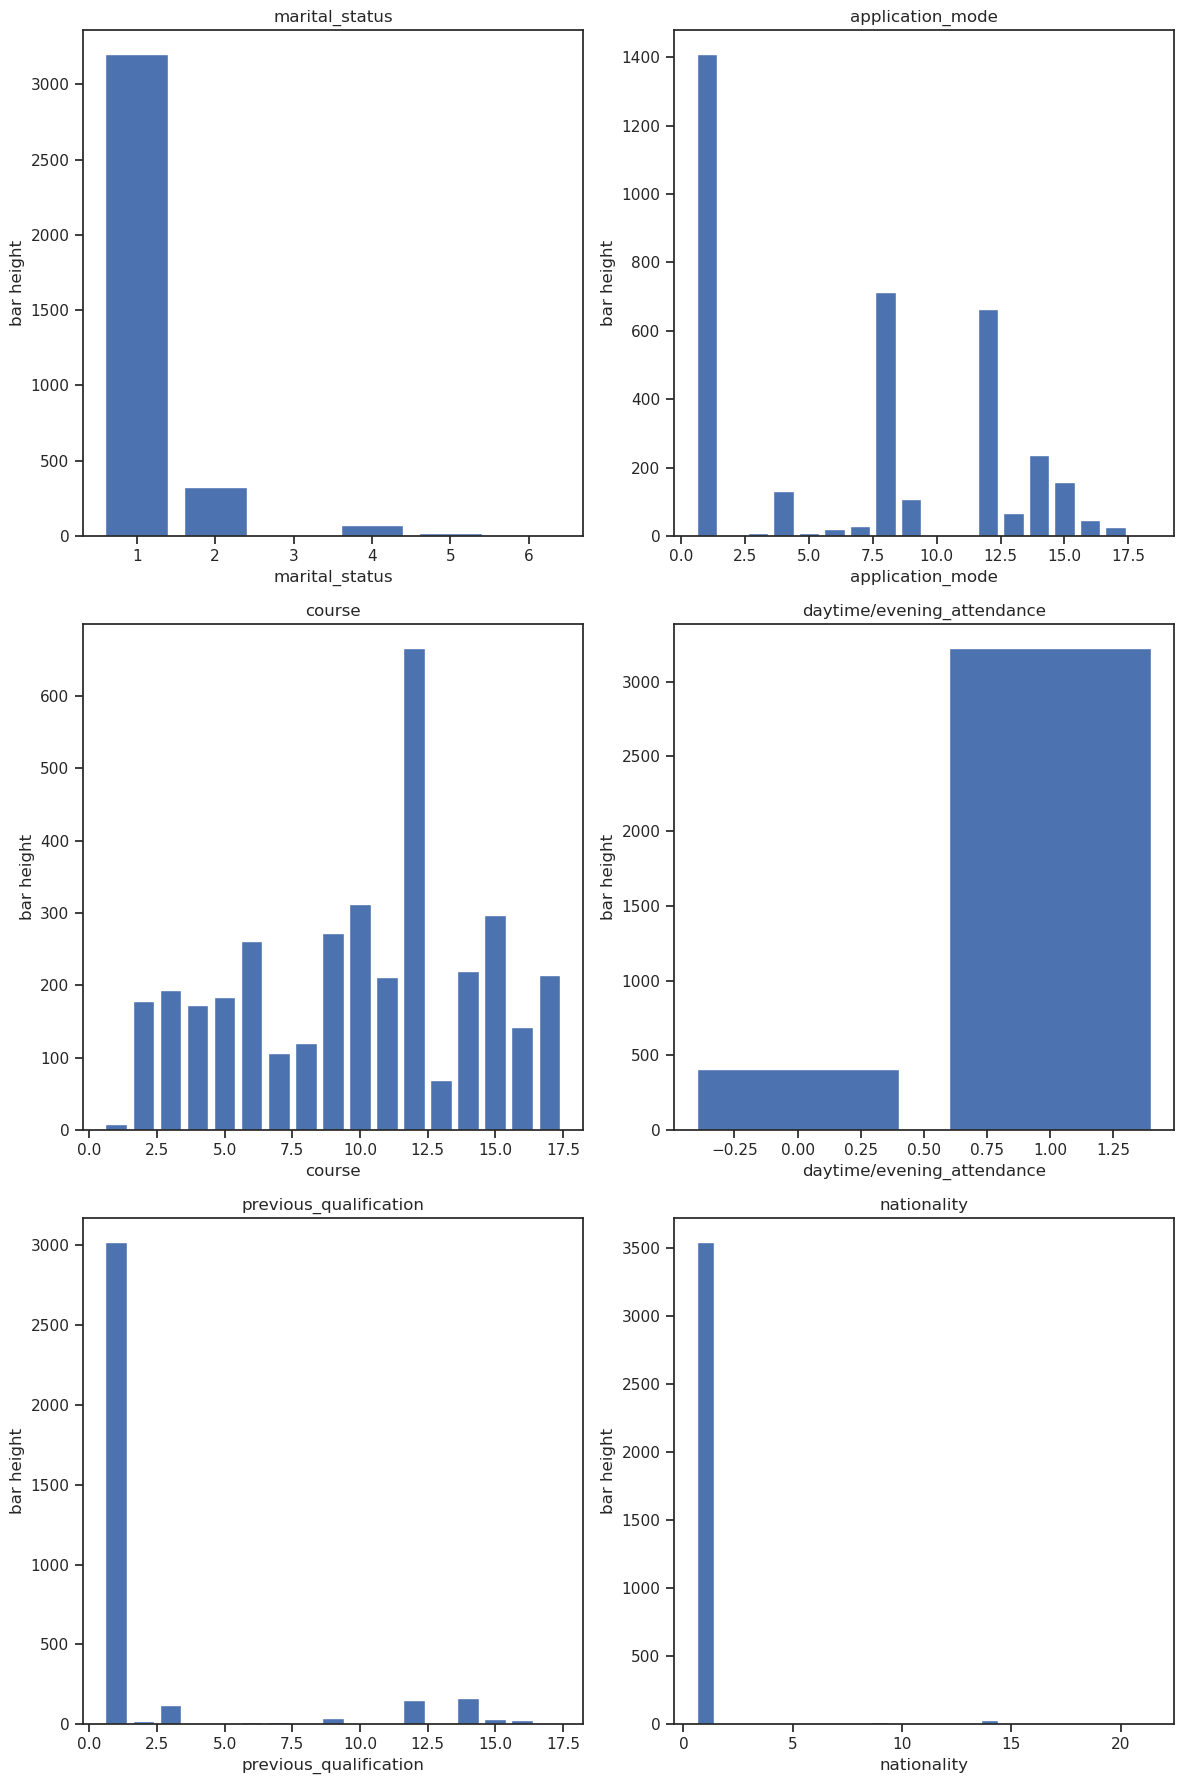

In [23]:
plot_categorical_columns(df, ['marital_status', 'application_mode', 'course', 'daytime/evening_attendance'
      ,'previous_qualification','nationality'])

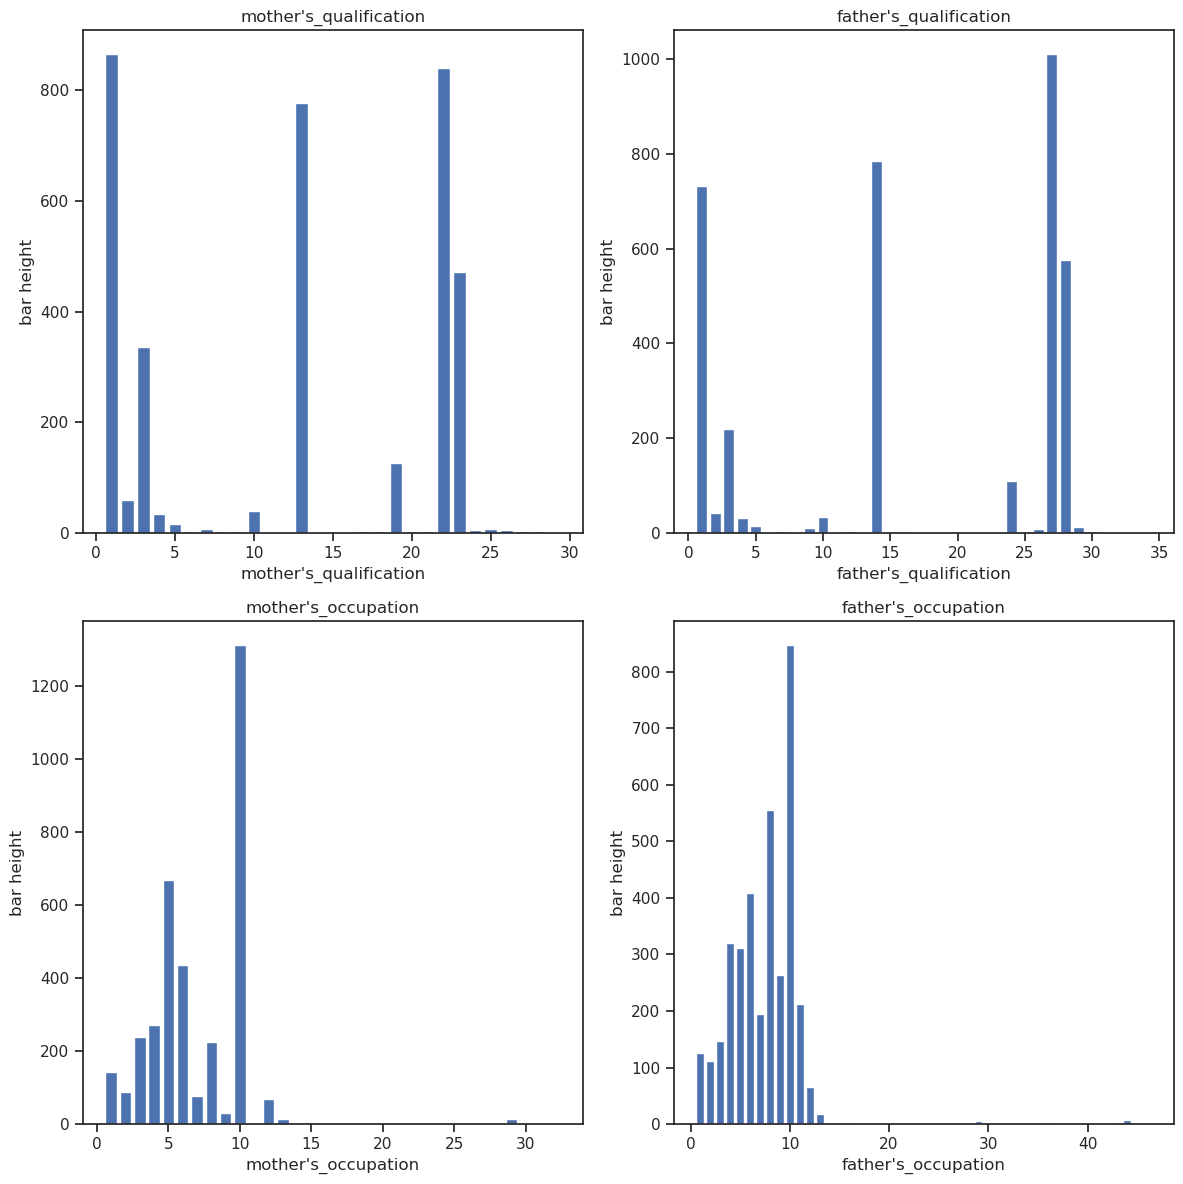

In [24]:
plot_categorical_columns(df, ["mother's_qualification", "father's_qualification",
       "mother's_occupation", "father's_occupation"])

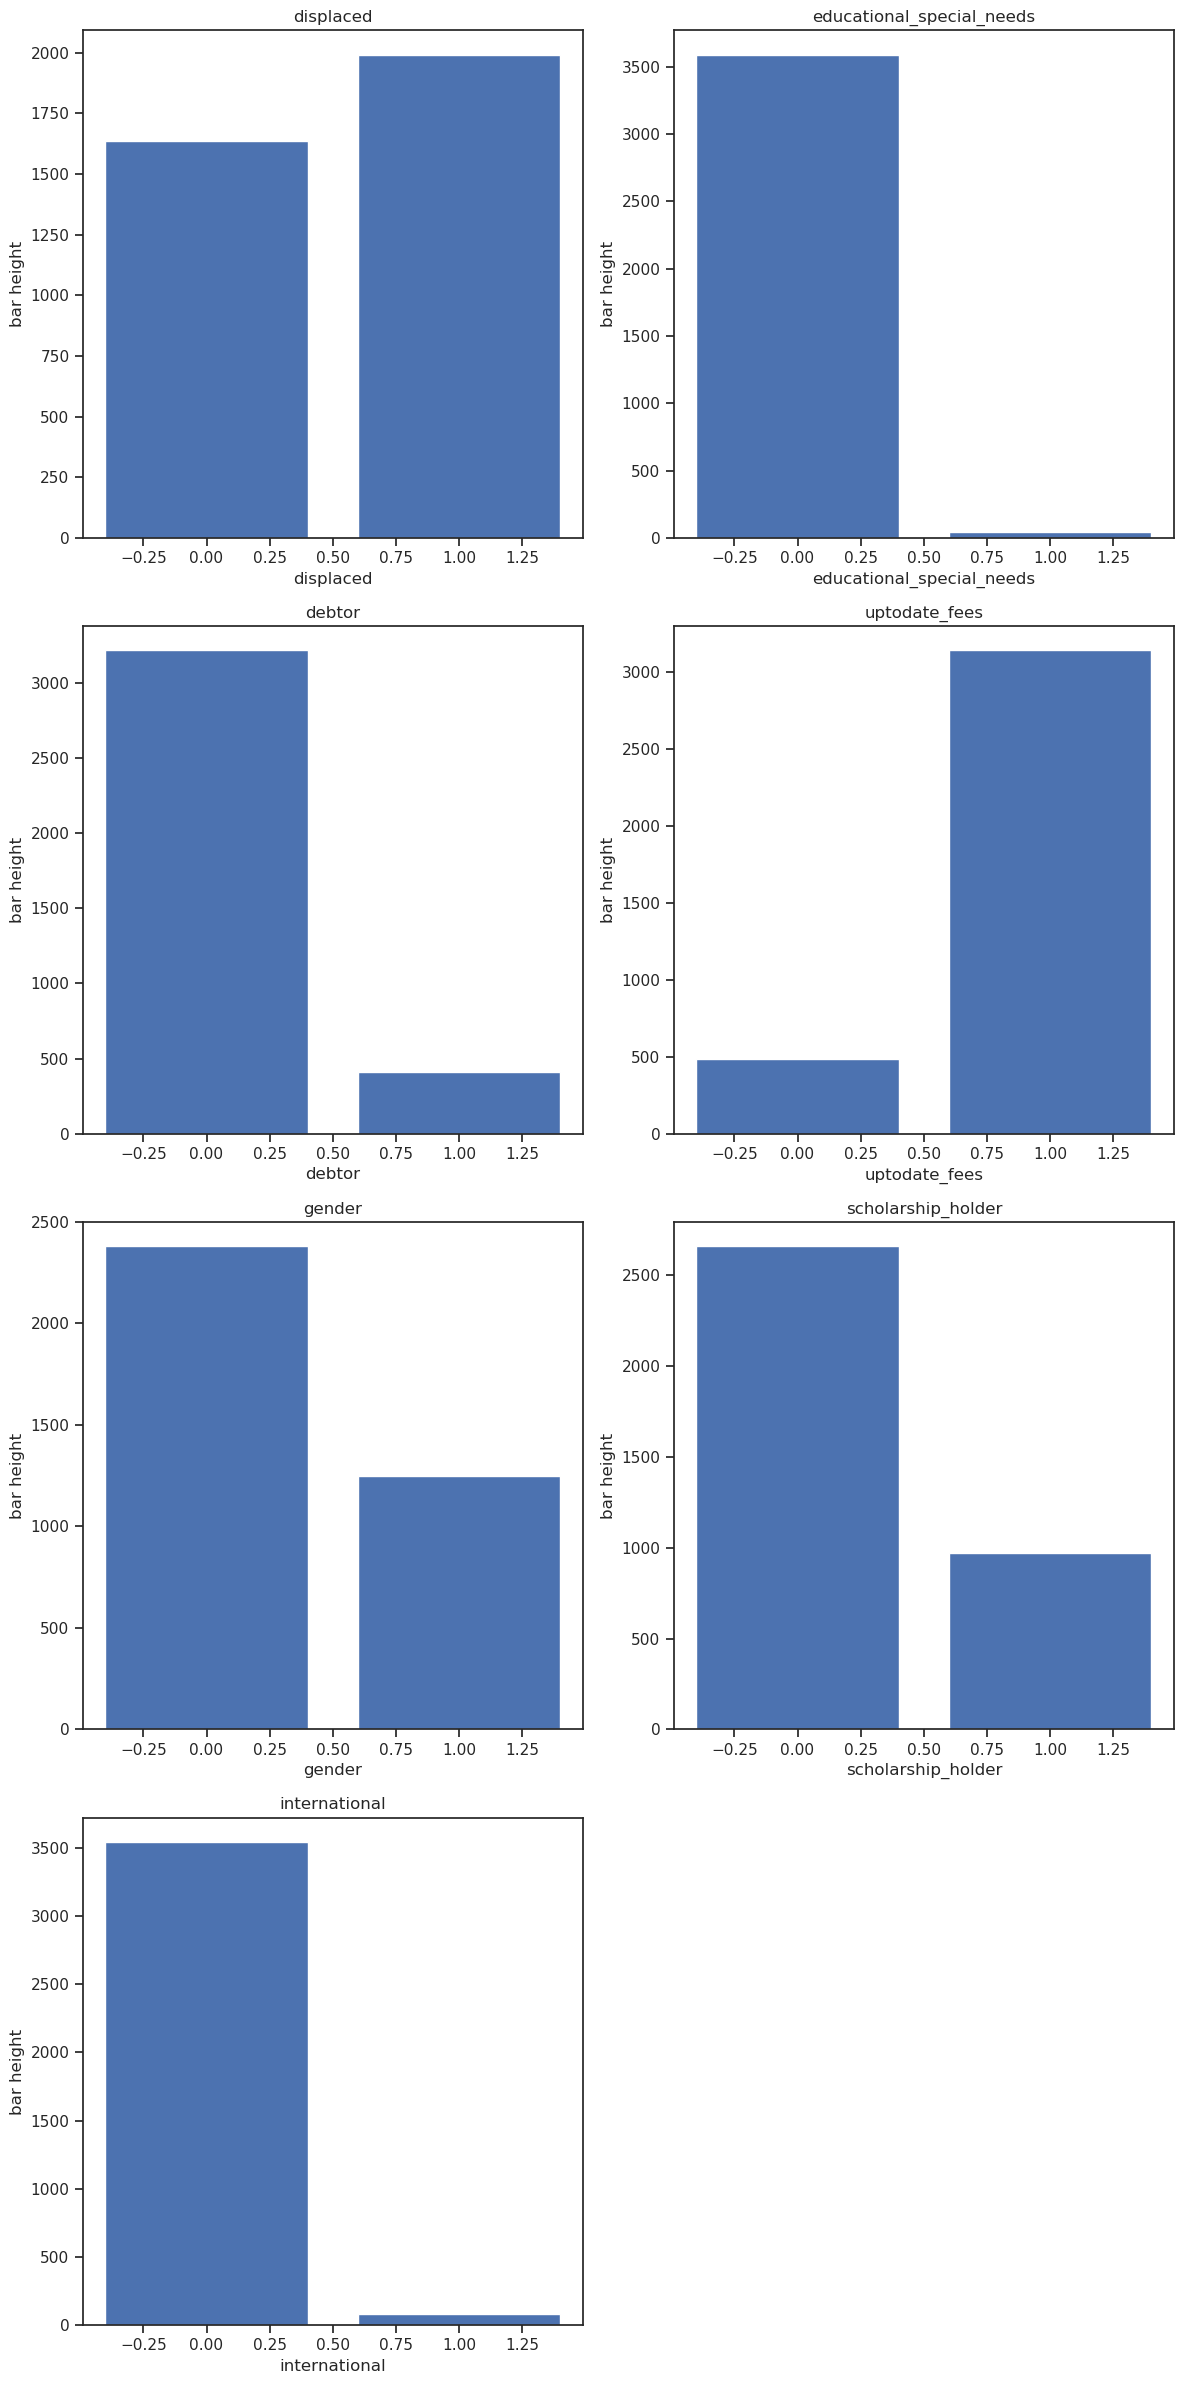

In [25]:
plot_categorical_columns(df, ['displaced', 'educational_special_needs',
       'debtor', 'uptodate_fees', 'gender', 'scholarship_holder', 'international'])

In [26]:
features_to_drop = ['1stsem_credited', '1stsem_without_evaluations', '2ndsem_credited', '2ndsem_without_evaluations','unemployment_rate',
 'inflation_rate','gdp', ]

In [27]:
df = df.drop(features_to_drop, axis=1)

# setting up validation framework

In [28]:
df.target = (df.target == "dropout").astype(int)

In [29]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=5)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=5)

In [30]:
df_full_train = df_full_train.reset_index(drop=True)

In [31]:
df_train.shape[0], df_val.shape[0],df_test.shape[0]

(2178, 726, 726)

In [32]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [33]:
df_train.head()

,marital_status,application_mode,application_order,course,daytime/evening_attendance,previous_qualification,nationality,mother's_qualification,father's_qualification,mother's_occupation,...,international,1stsem_enrolled,1stsem_evaluations,1stsem_approved,1stsem_grade,2ndsem_enrolled,2ndsem_evaluations,2ndsem_approved,2ndsem_grade,target
0,1,12,1,4,1,1,1,23,28,10,...,0,6,6,0,0.000000,6,7,0,0.000000,1
1,1,1,1,5,1,1,1,1,14,5,...,0,6,6,6,13.166667,6,6,6,12.666667,0
2,1,1,3,12,1,1,1,13,1,10,...,0,8,8,7,12.214286,8,8,7,12.214286,0
3,2,12,1,3,0,1,1,22,27,10,...,0,6,8,6,12.000000,6,6,6,11.666667,0
4,2,1,1,17,0,3,1,1,3,5,...,0,5,5,5,10.800000,5,9,4,11.500000,0


In [34]:
y_train = df_train.target.values
y_val = df_val.target.values
y_test = df_test.target.values

In [35]:
del df_train["target"]
del df_test["target"]
del df_val["target"]

In [36]:
df_train.head()

,marital_status,application_mode,application_order,course,daytime/evening_attendance,previous_qualification,nationality,mother's_qualification,father's_qualification,mother's_occupation,...,enrollment_age,international,1stsem_enrolled,1stsem_evaluations,1stsem_approved,1stsem_grade,2ndsem_enrolled,2ndsem_evaluations,2ndsem_approved,2ndsem_grade
0,1,12,1,4,1,1,1,23,28,10,...,28,0,6,6,0,0.000000,6,7,0,0.000000
1,1,1,1,5,1,1,1,1,14,5,...,20,0,6,6,6,13.166667,6,6,6,12.666667
2,1,1,3,12,1,1,1,13,1,10,...,18,0,8,8,7,12.214286,8,8,7,12.214286
3,2,12,1,3,0,1,1,22,27,10,...,33,0,6,8,6,12.000000,6,6,6,11.666667
4,2,1,1,17,0,3,1,1,3,5,...,23,0,5,5,5,10.800000,5,9,4,11.500000


# Feature Importance

In [37]:
categorical_columns = df.select_dtypes(include=['category']).columns

In [38]:
mutual_info = df_full_train[categorical_columns].apply(lambda x: mutual_info_score(x,df_full_train.target))
mutual_info = mutual_info.sort_values(ascending=False)

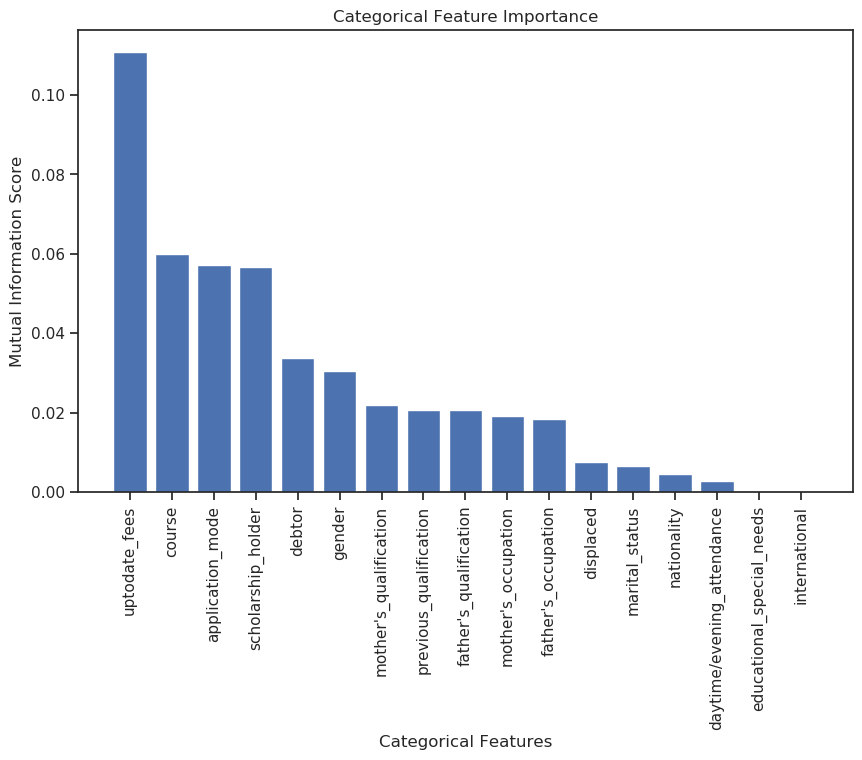

In [39]:
# Create a bar plot to visualize the feature importance
plt.figure(figsize=(10, 6))
plt.bar(mutual_info.index, mutual_info.values)
plt.title("Categorical Feature Importance")
plt.xlabel("Categorical Features")
plt.ylabel("Mutual Information Score")
plt.xticks(rotation=90)
plt.show()

In [40]:
important_cats = ['uptodate_fees', 'course', 'application_mode', 'scholarship_holder','debtor', 'gender']

In [41]:
corr_info = df_full_train.corrwith(df_full_train.target)
corr_info.sort_values(ascending=False)

target                1.000000
enrollment_age        0.266911
1stsem_evaluations   -0.052325
application_order    -0.085035
2ndsem_evaluations   -0.102908
1stsem_enrolled      -0.143761
2ndsem_enrolled      -0.166992
1stsem_grade         -0.513289
1stsem_approved      -0.544616
2ndsem_grade         -0.596568
2ndsem_approved      -0.644659
dtype: float64

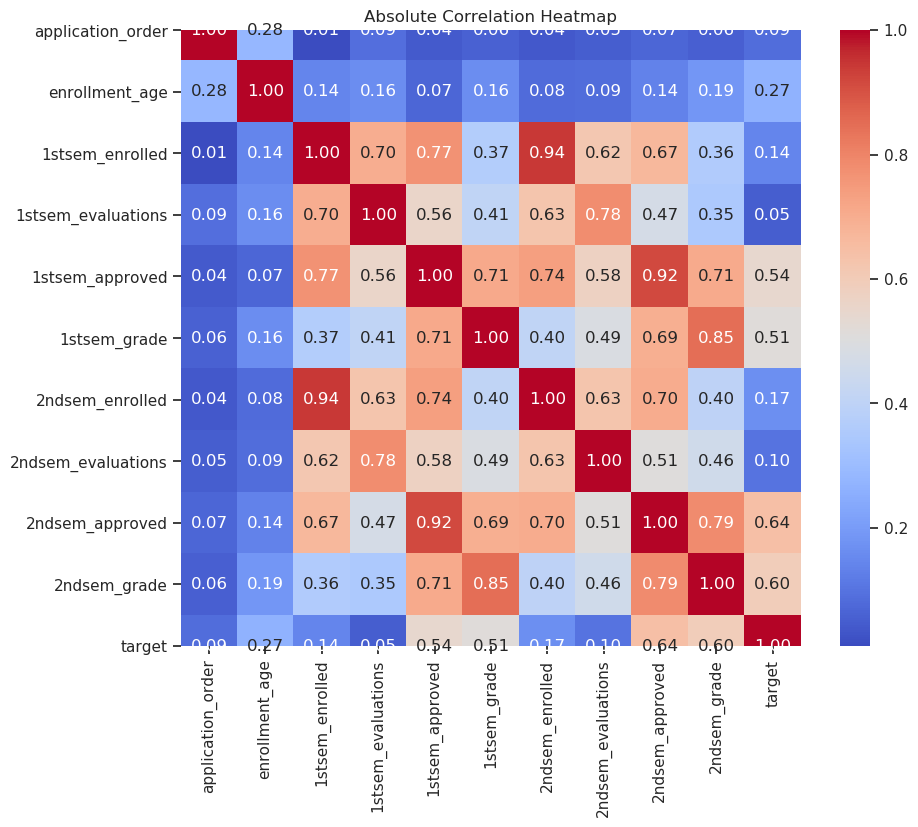

In [42]:
corr_matrix = df_full_train.corr().abs()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Absolute Correlation Heatmap')
plt.show()

In [43]:
numerical_columns = ['application_order',
 'enrollment_age',
 '1stsem_enrolled',
 '1stsem_evaluations',
 '1stsem_approved',
 '1stsem_grade',
 '2ndsem_enrolled',
 '2ndsem_evaluations',
 '2ndsem_approved',
 '2ndsem_grade']

# Model Trainning 

In [44]:
def logistic_train(df_train, y_train,columns, C=1):
    dicts = df_train[columns].to_dict(orient="records")
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train,y_train)
    
    return dv, model

In [45]:
def logistic_predict(df, dv, model,columns):
    dicts = df[columns].to_dict("records")
    X = dv.transform(dicts)
    pred = model.predict_proba(X)[:,1]
    return pred

In [46]:
df_train.shape, df_val.shape,df_test.shape

((2178, 27), (726, 27), (726, 27))

In [47]:
# test 1 all columns
dv, model = logistic_train(df_train, y_train,df_train.columns)
y_pred =logistic_predict(df_val, dv, model,df_val.columns)
auc = roc_auc_score(y_val, y_pred)
auc

0.9570714331352629

In [48]:
df_val.head()

,marital_status,application_mode,application_order,course,daytime/evening_attendance,previous_qualification,nationality,mother's_qualification,father's_qualification,mother's_occupation,...,enrollment_age,international,1stsem_enrolled,1stsem_evaluations,1stsem_approved,1stsem_grade,2ndsem_enrolled,2ndsem_evaluations,2ndsem_approved,2ndsem_grade
0,1,8,1,15,1,1,1,22,27,10,...,18,0,6,7,6,12.857143,6,6,6,13.333333
1,1,9,3,5,1,1,1,1,1,4,...,18,0,6,6,2,12.000000,6,6,1,11.000000
2,5,13,1,11,1,2,1,22,27,5,...,32,0,15,21,13,12.692308,15,22,13,12.384615
3,1,13,1,7,1,1,1,13,27,10,...,25,0,5,5,0,0.000000,6,7,2,14.000000
4,1,13,1,12,1,1,1,13,1,10,...,33,0,14,20,14,13.072857,14,20,14,13.072857


In [49]:
#test 2 using k-fold and finding best C
kfold = KFold(n_splits=10, shuffle=True,random_state=1 )
for C in tqdm([0.0001,0.001, 0.01, 0.1, 1, 5, 10]):
    auc_scores =[]
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.target.values
        y_val = df_val.target.values
        
        del df_train["target"]
        del df_val["target"]

        dv, model = logistic_train(df_train, y_train,df_train.columns, C)
        y_pred = logistic_predict(df_val, dv, model,df_val.columns)

        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)
    print(f"{C}:{round(np.mean(auc_scores), 3)} +- {round(np.std(auc_scores),3)}")

  0%|          | 0/7 [00:00<?, ?it/s]

0.0001:0.905 +- 0.019
0.001:0.929 +- 0.016
0.01:0.944 +- 0.014
0.1:0.951 +- 0.013
1:0.951 +- 0.013
5:0.951 +- 0.012
10:0.951 +- 0.012


In [50]:
# test 3 with only important columns
dv, model = logistic_train(df_train, y_train,list(important_cats)+list(numerical_columns))
y_pred =logistic_predict(df_test, dv, model,list(important_cats)+list(numerical_columns))
auc = roc_auc_score(y_test, y_pred)
auc

0.9541404776869893

In [51]:
# test 3 with only important columns using k-fold and finding best C
kfold = KFold(n_splits=10, shuffle=True,random_state=1 )
for C in tqdm([0.0001,0.001, 0.01, 0.1, 1, 5, 10]):
    auc_scores =[]
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.target.values
        y_val = df_val.target.values
        
        del df_train["target"]
        del df_val["target"]

        dv, model = logistic_train(df_train, y_train,list(important_cats)+list(numerical_columns), C)
        y_pred = logistic_predict(df_val, dv, model,list(important_cats)+list(numerical_columns))

        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)
    print(f"{C}:{round(np.mean(auc_scores), 3)} +- {round(np.std(auc_scores),3)}")

  0%|          | 0/7 [00:00<?, ?it/s]

0.0001:0.904 +- 0.019
0.001:0.928 +- 0.016
0.01:0.943 +- 0.014
0.1:0.949 +- 0.014
1:0.949 +- 0.014
5:0.95 +- 0.014
10:0.95 +- 0.014


In [1]:
#test 4 fit decistion threes
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# Predict enrolled student dropout

In [66]:
#full data set fitting
dv, model = logistic_train(df_full_train, df_full_train.target,df_full_train.columns)
y_pred =logistic_predict(df_test, dv, model,df_test.columns)
auc = roc_auc_score(y_test, y_pred)
auc

0.957723130106851

In [62]:
enrolled_no_taget = enrolled_df.drop("target", axis=1)
enrolled_no_taget.shape

(794, 34)

In [63]:
enrolled_no_taget = enrolled_no_taget.drop(features_to_drop, axis=1)

In [69]:
y_pred =logistic_predict(enrolled_no_taget, dv, model,enrolled_no_taget.columns)
dropout_score = (y_pred >= 0.5).mean()
dropout_score

0.003778337531486146

# save model

In [68]:
output_file = f"dropout1.bin"
output_file
with open(output_file, "wb") as f_out:
    pickle.dump((dv,model), f_out)

In [72]:
student = {'marital_status': 1.0,
 'application_mode': 17.0,
 'application_order': 1.0,
 'course': 13.0,
 'daytime/evening_attendance': 1.0,
 'previous_qualification': 16.0,
 'nationality': 1.0,
 "mother's_qualification": 1.0,
 "father's_qualification": 14.0,
 "mother's_occupation": 5.0,
 "father's_occupation": 6.0,
 'displaced': 0.0,
 'educational_special_needs': 0.0,
 'debtor': 0.0,
 'uptodate_fees': 1.0,
 'gender': 0.0,
 'scholarship_holder': 1.0,
 'enrollment_age': 22.0,
 'international': 0.0,
 '1stsem_enrolled': 7.0,
 '1stsem_evaluations': 10.0,
 '1stsem_approved': 6.0,
 '1stsem_grade': 13.3142857142857,
 '2ndsem_enrolled': 8.0,
 '2ndsem_evaluations': 10.0,
 '2ndsem_approved': 7.0,
 '2ndsem_grade': 12.875}

In [73]:
import requests

url = "http://0.0.0.0:9696//predict"

requests.post(url, json=student).json()

{'Drop out': False, 'Drop out probability': 0.10962615094623009}